<a href="https://colab.research.google.com/github/sidc124/Alzhimer-Detection/blob/main/multiclass_customcnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Alzheimer's vs. Dementia EEG Classification — End-to-End Deep Learning Pipeline

This notebook implements the full pipeline you described:
1) **Find common channels** across OpenNeuro datasets and align them  
2) **Preprocess** (filtering, referencing, resampling)  
3) **Segment** signals into fixed-size windows and **standardize shapes** (pad/crop)  
4) **Build datasets** and loaders for train/val/test (subject-wise splits)  
5) **Train baselines** (EEGNet) and a **custom hybrid model** that aims to outperform EEGNet  
6) **Evaluate & cross-test** across datasets (train on one, test on the other)  
7) **Result analysis** with metrics and confusion matrices

## 1. Setup & Config

In [1]:
from google.colab import drive
drive.mount('/content/drive')
!ls "/content/drive/MyDrive/EEG_Project/dataset_2/sub-hc1/ses-hc/eeg"
import glob
import os

# Base directory in Google Drive
base_path = "/content/drive/MyDrive/EEG_Project"

# Find all .set and .bdf files
set_files = glob.glob(os.path.join(base_path, "**", "*.set"), recursive=True)
bdf_files = glob.glob(os.path.join(base_path, "**", "*.bdf"), recursive=True)

print(f"Found {len(set_files)} .set files")
print(f"Found {len(bdf_files)} .bdf files")

# Check a few results
print("Example .set file:", set_files[0] if set_files else "None found")
print("Example .bdf file:", bdf_files[0] if bdf_files else "None found")


Mounted at /content/drive
sub-hc1_ses-hc_task-rest_channels.tsv  sub-hc1_ses-hc_task-rest_eeg.json
sub-hc1_ses-hc_task-rest_eeg.bdf       sub-hc1_ses-hc_task-rest_events.tsv
Found 88 .set files
Found 45 .bdf files
Example .set file: /content/drive/MyDrive/EEG_Project/dataset_1/sub-005/eeg/sub-005_task-eyesclosed_eeg.set
Example .bdf file: /content/drive/MyDrive/EEG_Project/dataset_2/sub-hc7/ses-hc/eeg/sub-hc7_ses-hc_task-rest_eeg.bdf


## 2. Channels finding and common channels

In [2]:

!pip install mne
import mne

# Pick one file from each dataset
sample_set_file = set_files[0]
sample_bdf_file = bdf_files[0]

# Load raw data without preprocessing
raw_set = mne.io.read_raw_eeglab(sample_set_file, preload=False)
raw_bdf = mne.io.read_raw_bdf(sample_bdf_file, preload=False)

# Get channel names
channels_set = raw_set.info["ch_names"]
channels_bdf = raw_bdf.info["ch_names"]

print("Channels in .set dataset:", channels_set)
print("Channels in .bdf dataset:", channels_bdf)

# Find common channels
common_channels = list(set(channels_set).intersection(set(channels_bdf)))
print(f"Number of common channels: {len(common_channels)}")
print("Common channels:", common_channels)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 78.1 MB/s eta 0:00:00


/tmp/ipython-input-1621918465.py:9: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw_set = mne.io.read_raw_eeglab(sample_set_file, preload=False)


Extracting EDF parameters from /content/drive/MyDrive/EEG_Project/dataset_2/sub-hc7/ses-hc/eeg/sub-hc7_ses-hc_task-rest_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Channels in .set dataset: ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
Channels in .bdf dataset: ['Fp1', 'AF3', 'F7', 'F3', 'FC1', 'FC5', 'T7', 'C3', 'CP1', 'CP5', 'P7', 'P3', 'Pz', 'PO3', 'O1', 'Oz', 'O2', 'PO4', 'P4', 'P8', 'CP6', 'CP2', 'C4', 'T8', 'FC6', 'FC2', 'F4', 'F8', 'AF4', 'Fp2', 'Fz', 'Cz', 'EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'Status']
Number of common channels: 15
Common channels: ['Fz', 'Pz', 'Fp1', 'P4', 'P3', 'Fp2', 'C3', 'F3', 'C4', 'O2', 'F4', 'F7', 'O1', 'F8', 'Cz']


## 3. reordering the dataset


In [4]:
import mne

# We will use the order from the .set dataset
ordered_common_channels = [ch for ch in channels_set if ch in common_channels]

print("Final channel order:", ordered_common_channels)

# Function to load and reorder channels
def load_and_reorder(filepath, filetype, channel_order):
    if filetype == "set":
        raw = mne.io.read_raw_eeglab(filepath, preload=True)
    elif filetype == "bdf":
        raw = mne.io.read_raw_bdf(filepath, preload=True)
    else:
        raise ValueError("Unsupported file type")

    # Pick only common channels and reorder
    raw.pick_channels(channel_order)
    raw.reorder_channels(channel_order)

    return raw

# Load all .set files in same channel order
all_set_data = [load_and_reorder(f, "set", ordered_common_channels) for f in set_files]

# Load all .bdf files in same channel order
all_bdf_data = [load_and_reorder(f, "bdf", ordered_common_channels) for f in bdf_files]


Final channel order: ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'Fz', 'Cz', 'Pz']
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)
/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)
/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)
/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)
/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Extracting EDF parameters from /content/drive/MyDrive/EEG_Project/dataset_2/sub-hc7/ses-hc/eeg/sub-hc7_ses-hc_task-rest_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 98303  =      0.000 ...   191.998 secs...


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Extracting EDF parameters from /content/drive/MyDrive/EEG_Project/dataset_2/sub-hc1/ses-hc/eeg/sub-hc1_ses-hc_task-rest_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 98303  =      0.000 ...   191.998 secs...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Extracting EDF parameters from /content/drive/MyDrive/EEG_Project/dataset_2/sub-hc2/ses-hc/eeg/sub-hc2_ses-hc_task-rest_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 99327  =      0.000 ...   193.998 secs...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Extracting EDF parameters from /content/drive/MyDrive/EEG_Project/dataset_2/sub-hc21/ses-hc/eeg/sub-hc21_ses-hc_task-rest_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Read

## 4. checking if the order is same or not


In [5]:
# Check first 3 files from each dataset to verify channel order
for i, raw_obj in enumerate(all_set_data[:7]):
    print(f"\nSET file {i+1} channels:")
    print(raw_obj.info["ch_names"])

for i, raw_obj in enumerate(all_bdf_data[:7]):
    print(f"\nBDF file {i+1} channels:")
    print(raw_obj.info["ch_names"])

# Final check: compare channel order between first SET and first BDF
set_order = all_set_data[0].info["ch_names"]
bdf_order = all_bdf_data[0].info["ch_names"]

if set_order == bdf_order:
    print("\n✅ Channel orders match for SET and BDF datasets.")
else:
    print("\n❌ Channel orders do NOT match.")
    print("SET order:", set_order)
    print("BDF order:", bdf_order)



SET file 1 channels:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'Fz', 'Cz', 'Pz']

SET file 2 channels:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'Fz', 'Cz', 'Pz']

SET file 3 channels:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'Fz', 'Cz', 'Pz']

SET file 4 channels:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'Fz', 'Cz', 'Pz']

SET file 5 channels:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'Fz', 'Cz', 'Pz']

SET file 6 channels:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'Fz', 'Cz', 'Pz']

SET file 7 channels:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'Fz', 'Cz', 'Pz']

BDF file 1 channels:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'Fz', 'Cz', 'Pz']

BDF file 2 channels:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', '

##5. checking the sampling freuquency

## 6. Resampling

In [6]:
target_sfreq = 256  # Hz

# Resample .set files
for i, raw in enumerate(all_set_data):
    if raw.info['sfreq'] != target_sfreq:
        raw.resample(target_sfreq)
        print(f"Resampled .set file {i+1} to {target_sfreq} Hz")

# Resample .bdf files
for i, raw in enumerate(all_bdf_data):
    if raw.info['sfreq'] != target_sfreq:
        raw.resample(target_sfreq)
        print(f"Resampled .bdf file {i+1} to {target_sfreq} Hz")


Resampled .set file 1 to 256 Hz
Resampled .set file 2 to 256 Hz
Resampled .set file 3 to 256 Hz
Resampled .set file 4 to 256 Hz
Resampled .set file 5 to 256 Hz
Resampled .set file 6 to 256 Hz
Resampled .set file 7 to 256 Hz
Resampled .set file 8 to 256 Hz
Resampled .set file 9 to 256 Hz
Resampled .set file 10 to 256 Hz
Resampled .set file 11 to 256 Hz
Resampled .set file 12 to 256 Hz
Resampled .set file 13 to 256 Hz
Resampled .set file 14 to 256 Hz
Resampled .set file 15 to 256 Hz
Resampled .set file 16 to 256 Hz
Resampled .set file 17 to 256 Hz
Resampled .set file 18 to 256 Hz
Resampled .set file 19 to 256 Hz
Resampled .set file 20 to 256 Hz
Resampled .set file 21 to 256 Hz
Resampled .set file 22 to 256 Hz
Resampled .set file 23 to 256 Hz
Resampled .set file 24 to 256 Hz
Resampled .set file 25 to 256 Hz
Resampled .set file 26 to 256 Hz
Resampled .set file 27 to 256 Hz
Resampled .set file 28 to 256 Hz
Resampled .set file 29 to 256 Hz
Resampled .set file 30 to 256 Hz
Resampled .set file

##6. normalization


In [7]:
import numpy as np

# ===== 1️⃣ Shortest recording length =====
min_times = min([raw.n_times for raw in all_set_data + all_bdf_data])
print(f"Minimum common length (time points): {min_times}")

# ===== 2️⃣ Combine datasets =====
X_all = []

for raw in all_set_data:
    X_all.append(raw.get_data()[:, :min_times])

for raw in all_bdf_data:
    X_all.append(raw.get_data()[:, :min_times])

X_all = np.array(X_all)  # (n_samples, n_channels, n_times)
print(f"✅ Combined dataset shape (raw): {X_all.shape}")

# ===== 3️⃣ Normalize per sample, per channel =====
X_scaled = np.zeros_like(X_all, dtype=np.float32)

for i in range(X_all.shape[0]):           # loop over samples
    for ch in range(X_all.shape[1]):      # loop over channels
        ch_data = X_all[i, ch, :]
        mean = np.mean(ch_data)
        std = np.std(ch_data)
        if std > 0:   # avoid divide by zero
            X_scaled[i, ch, :] = (ch_data - mean) / std
        else:
            X_scaled[i, ch, :] = ch_data - mean  # flat channel

print(f"✅ Normalized dataset shape: {X_scaled.shape}")

# ===== 4️⃣ Save ONLY normalized dataset =====
np.save("X_normalized.npy", X_scaled)
np.save('/content/drive/MyDrive/X_normalized.npy', X_scaled)

print("💾 Saved normalized dataset as 'X_normalized.npy' (local + Google Drive)")


Minimum common length (time points): 46336
✅ Combined dataset shape (raw): (133, 15, 46336)
✅ Normalized dataset shape: (133, 15, 46336)
💾 Saved normalized dataset as 'X_normalized.npy' (local + Google Drive)


In [8]:
import numpy as np

# Load normalized data
X_normalized = np.load('/content/drive/MyDrive/X_normalized.npy')

print("✅ X_normalized loaded")
print("Shape:", X_normalized.shape)   # (n_samples, n_channels, n_times)
print("Data type:", X_normalized.dtype)

# Check overall statistics
print("\n=== Statistics ===")
print("Min:", np.min(X_normalized))
print("Max:", np.max(X_normalized))
print("Mean:", np.mean(X_normalized))
print("Std Dev:", np.std(X_normalized))

# Check one sample (first recording)
sample_idx = 0
print(f"\n=== Sample {sample_idx} details ===")
print("Shape:", X_normalized[sample_idx].shape)
print("Mean:", np.mean(X_normalized[sample_idx]))
print("Std Dev:", np.std(X_normalized[sample_idx]))

# Check across channels for the first sample
print("\n=== First sample channel-wise stats ===")
for ch in range(min(5, X_normalized.shape[1])):  # show first 5 channels
    ch_data = X_normalized[sample_idx, ch, :]
    print(f"Channel {ch}: mean={np.mean(ch_data):.4f}, std={np.std(ch_data):.4f}")


✅ X_normalized loaded
Shape: (133, 15, 46336)
Data type: float32

=== Statistics ===
Min: -26.498531
Max: 32.419365
Mean: 6.602655e-12
Std Dev: 1.0000008

=== Sample 0 details ===
Shape: (15, 46336)
Mean: -1.7453293e-09
Std Dev: 0.99999994

=== First sample channel-wise stats ===
Channel 0: mean=-0.0000, std=1.0000
Channel 1: mean=-0.0000, std=1.0000
Channel 2: mean=-0.0000, std=1.0000
Channel 3: mean=-0.0000, std=1.0000
Channel 4: mean=0.0000, std=1.0000


In [9]:
import numpy as np

# Load the .npy file
data = np.load('/content/drive/MyDrive/X_normalized.npy')

# Now you can inspect the 'data' variable
# For example, to see its shape:
print(data.shape)

# To see its data type:
print(data.dtype)

(133, 15, 46336)
float32


## 9. Save Metrics & Plots

In [10]:
for i, sample in enumerate(X_all):
    print(f"Sample {i+1} shape: {sample.shape}")


Sample 1 shape: (15, 46336)
Sample 2 shape: (15, 46336)
Sample 3 shape: (15, 46336)
Sample 4 shape: (15, 46336)
Sample 5 shape: (15, 46336)
Sample 6 shape: (15, 46336)
Sample 7 shape: (15, 46336)
Sample 8 shape: (15, 46336)
Sample 9 shape: (15, 46336)
Sample 10 shape: (15, 46336)
Sample 11 shape: (15, 46336)
Sample 12 shape: (15, 46336)
Sample 13 shape: (15, 46336)
Sample 14 shape: (15, 46336)
Sample 15 shape: (15, 46336)
Sample 16 shape: (15, 46336)
Sample 17 shape: (15, 46336)
Sample 18 shape: (15, 46336)
Sample 19 shape: (15, 46336)
Sample 20 shape: (15, 46336)
Sample 21 shape: (15, 46336)
Sample 22 shape: (15, 46336)
Sample 23 shape: (15, 46336)
Sample 24 shape: (15, 46336)
Sample 25 shape: (15, 46336)
Sample 26 shape: (15, 46336)
Sample 27 shape: (15, 46336)
Sample 28 shape: (15, 46336)
Sample 29 shape: (15, 46336)
Sample 30 shape: (15, 46336)
Sample 31 shape: (15, 46336)
Sample 32 shape: (15, 46336)
Sample 33 shape: (15, 46336)
Sample 34 shape: (15, 46336)
Sample 35 shape: (15, 4

In [11]:
import numpy as np
import pandas as pd
from pathlib import Path

# ===== 1️⃣ Load participant metadata =====
df_set = pd.read_csv("/content/drive/MyDrive/EEG_Project/participants_set.tsv", sep="\t")
df_bdf = pd.read_csv("/content/drive/MyDrive/EEG_Project/participants_bdf.tsv", sep="\t")

# Map groups to labels (Healthy=0, AD=1, PD=2, Dementia=3)
# Based on the documentation:
# dataset_1 (set files): A - AD, F - FTD (Dementia), C - Control (Healthy)
# dataset_2 (bdf files): hc - Healthy Control, pd - Parkinson's Disease (PD)

group_map_set = {'A': 1, 'F': 3, 'C': 0} # AD=1, Dementia=3, Healthy=0
df_set["label"] = df_set["Group"].map(group_map_set)

# For BDF, 'hc' is Healthy (0), 'pd' is Parkinson's Disease (2)
df_bdf["label"] = df_bdf["participant_id"].apply(lambda x: 0 if "hc" in x.lower() else 2) # Healthy=0, PD=2


print("=== SET Metadata ===")
print(df_set.head())
print("=== BDF Metadata ===")
print(df_bdf.head())

# ===== 2️⃣ Load normalized data =====
X_normalized = np.load('/content/drive/MyDrive/X_normalized.npy')
print("✅ Loaded normalized dataset:", X_normalized.shape)

# ===== 3️⃣ Match participant IDs with labels =====
ids_set = [Path(raw.filenames[0]).parts[-3] for raw in all_set_data]
ids_bdf = [Path(raw.filenames[0]).parts[-4] for raw in all_bdf_data]

# Check for missing IDs in metadata - still useful for verification
missing_set = [sid for sid in ids_set if sid not in df_set["participant_id"].values]
missing_bdf = [sid for sid in ids_bdf if sid not in df_bdf["participant_id"].values]
print("Missing from SET metadata:", missing_set)
print("Missing from BDF metadata:", missing_bdf)

# ===== 4️⃣ Build labels array =====
y_all = []
id_all = []

# Get labels from SET data
for raw in all_set_data:
    sid = Path(raw.filenames[0]).parts[-3]
    # Ensure the participant ID exists in the metadata before accessing the label
    if sid in df_set["participant_id"].values:
        label = df_set.loc[df_set["participant_id"] == sid, "label"].values[0]
        y_all.append(label)
        id_all.append(sid)
    else:
        print(f"Warning: Participant ID {sid} from SET file not found in SET metadata. Skipping.")


# Get labels from BDF data
for raw in all_bdf_data:
    sid = Path(raw.filenames[0]).parts[-4]
    # Ensure the participant ID exists in the metadata before accessing the label
    if sid in df_bdf["participant_id"].values:
        label = df_bdf.loc[df_bdf["participant_id"] == sid, "label"].values[0]
        y_all.append(label)
        id_all.append(sid)
    else:
         print(f"Warning: Participant ID {sid} from BDF file not found in BDF metadata. Skipping.")


y_all = np.array(y_all)
id_all = np.array(id_all)

print("✅ Labels shape:", y_all.shape)
print("Class distribution:\n", pd.Series(y_all).value_counts())

# ===== 5️⃣ Save labeled normalized dataset =====
np.save("X_normalized.npy", X_normalized)   # keep normalized data
np.save("y_all.npy", y_all)
np.save('/content/drive/MyDrive/X_normalized.npy', X_normalized)
np.save('/content/drive/MyDrive/y_all.npy', y_all)


pd.DataFrame({"ID": id_all, "label": y_all}).to_csv("id_labels.csv", index=False)
pd.DataFrame({"ID": id_all, "label": y_all}).to_csv("/content/drive/MyDrive/id_labels.csv", index=False) # Save to Drive as well


print("💾 Saved normalized X as 'X_normalized.npy', labels as 'y_all.npy', and ID-label mapping (local + Google Drive)")

=== SET Metadata ===
  participant_id Gender  Age Group  MMSE  label
0        sub-001      F   57     A    16      1
1        sub-002      F   78     A    22      1
2        sub-003      M   70     A    14      1
3        sub-004      F   67     A    20      1
4        sub-005      M   70     A    22      1
=== BDF Metadata ===
  participant_id  age gender hand  MMSE  NAART  disease_duration  \
0        sub-hc1   54      f    r    30     48               NaN   
1        sub-hc2   50      f    r    30     55               NaN   
2        sub-pd3   52      f    r    29     44               9.0   
3        sub-hc4   50      f    r    30     52               NaN   
4        sub-pd5   67      f    r    29     48               2.0   

                     rl_deficits notes  label  
0                            NaN   NaN      0  
1                            NaN   NaN      0  
2                              R   NaN      2  
3                            NaN   NaN      0  
4  No clear side, per

In [12]:
import pandas as pd


df_overview = pd.DataFrame({
    "ID": id_all,
    "Label": y_all
})


# Updated label_map for multi-class classification
label_map = {0: "Healthy", 1: "AD", 2: "PD", 3: "Dementia"}
df_overview["Label_Name"] = df_overview["Label"].map(label_map)


print(df_overview)


df_overview.to_csv("/content/drive/MyDrive/dataset_overview.csv", index=False)
print("💾 Saved to /content/drive/MyDrive/dataset_overview.csv")

print("\nClass distribution:")
print(df_overview["Label_Name"].value_counts())

           ID  Label Label_Name
0     sub-005      1         AD
1     sub-003      1         AD
2     sub-001      1         AD
3     sub-006      1         AD
4     sub-004      1         AD
..        ...    ...        ...
128  sub-pd23      2         PD
129  sub-pd23      2         PD
130  sub-pd26      2         PD
131  sub-pd26      2         PD
132  sub-pd28      2         PD

[133 rows x 3 columns]
💾 Saved to /content/drive/MyDrive/dataset_overview.csv

Class distribution:
Label_Name
Healthy     45
AD          36
PD          29
Dementia    23
Name: count, dtype: int64


In [ ]:
for i, arr in enumerate(X_all):
    print(f"Index {i}: shape = {np.array(arr).shape}")


Index 0: shape = (15, 46336)
Index 1: shape = (15, 46336)
Index 2: shape = (15, 46336)
Index 3: shape = (15, 46336)
Index 4: shape = (15, 46336)
Index 5: shape = (15, 46336)
Index 6: shape = (15, 46336)
Index 7: shape = (15, 46336)
Index 8: shape = (15, 46336)
Index 9: shape = (15, 46336)
Index 10: shape = (15, 46336)
Index 11: shape = (15, 46336)
Index 12: shape = (15, 46336)
Index 13: shape = (15, 46336)
Index 14: shape = (15, 46336)
Index 15: shape = (15, 46336)
Index 16: shape = (15, 46336)
Index 17: shape = (15, 46336)
Index 18: shape = (15, 46336)
Index 19: shape = (15, 46336)
Index 20: shape = (15, 46336)
Index 21: shape = (15, 46336)
Index 22: shape = (15, 46336)
Index 23: shape = (15, 46336)
Index 24: shape = (15, 46336)
Index 25: shape = (15, 46336)
Index 26: shape = (15, 46336)
Index 27: shape = (15, 46336)
Index 28: shape = (15, 46336)
Index 29: shape = (15, 46336)
Index 30: shape = (15, 46336)
Index 31: shape = (15, 46336)
Index 32: shape = (15, 46336)
Index 33: shape = (1

In [14]:
import numpy as np
from imblearn.over_sampling import SMOTE
from collections import Counter

# ===== 1️⃣ Load the data =====
X_normalized = np.load('/content/drive/MyDrive/X_normalized.npy')
y_all = np.load('/content/drive/MyDrive/y_all.npy')

print("Original Data Shape:", X_normalized.shape)
print("Original Labels Shape:", y_all.shape)
print("Original Class Distribution:", Counter(y_all))

# ===== 2️⃣ Reshape for SMOTE =====
n_samples, n_channels, n_times = X_normalized.shape
X_reshaped = X_normalized.reshape(n_samples, n_channels * n_times)

# ===== 3️⃣ Apply SMOTE with target of 100 samples per class =====
target_samples = 150
sampling_strategy = {0: target_samples, 1: target_samples, 2: target_samples, 3: target_samples}

print("\nApplying SMOTE...")
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_reshaped, y_all)

# ===== 4️⃣ Reshape back to original EEG format =====
X_resampled = X_resampled.reshape(-1, n_channels, n_times)

print("\n✅ SMOTE applied with target 100 samples per class.")
print("Resampled Data Shape:", X_resampled.shape)
print("Resampled Labels Shape:", y_resampled.shape)
print("Resampled Class Distribution:", Counter(y_resampled))

# ===== 5️⃣ Save the resampled data =====
np.save('/content/drive/MyDrive/X_resampled.npy', X_resampled)
np.save('/content/drive/MyDrive/y_resampled.npy', y_resampled)

print("\n💾 Files saved successfully:")
print("→ /content/drive/MyDrive/X_resampled.npy")
print("→ /content/drive/MyDrive/y_resampled.npy")


Original Data Shape: (133, 15, 46336)
Original Labels Shape: (133,)
Original Class Distribution: Counter({np.int64(0): 45, np.int64(1): 36, np.int64(2): 29, np.int64(3): 23})

Applying SMOTE...

✅ SMOTE applied with target 100 samples per class.
Resampled Data Shape: (600, 15, 46336)
Resampled Labels Shape: (600,)
Resampled Class Distribution: Counter({np.int64(1): 150, np.int64(0): 150, np.int64(3): 150, np.int64(2): 150})

💾 Files saved successfully:
→ /content/drive/MyDrive/X_resampled.npy
→ /content/drive/MyDrive/y_resampled.npy


In [ ]:
X = np.load('/content/drive/MyDrive/X_resampled.npy')
y = np.load('/content/drive/MyDrive/y_resampled.npy')


In [1]:
import os
import time
import os, time, glob
import numpy as np
import pandas as pd
import librosa as lb
from tqdm import tqdm
import seaborn as sns
from scipy.io import loadmat
from scipy.signal.windows import gaussian
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn import metrics
from keras.regularizers import l2
from tensorflow.random import set_seed
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D, AvgPool2D
from keras import Model, Input
from tensorflow.keras.optimizers import Adam
from keras.models import load_model

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from collections import Counter

# ===== 1️⃣ Load the already SMOTE-resampled dataset =====
X = np.load("/content/drive/MyDrive/X_resampled.npy")   # (N, 15, 46336)
y = np.load("/content/drive/MyDrive/y_resampled.npy")   # (N,)

print("✅ SMOTE-resampled data loaded.")
print("X shape:", X.shape)
print("y shape:", y.shape)
print("Class Distribution:", Counter(y))

# ===== 2️⃣ Split into Train (60%), Temp (40%) =====
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.40, random_state=42, stratify=y
)

# ===== 3️⃣ Split Temp into Validation (20%) and Test (20%) =====
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

# ===== 4️⃣ Print Summary =====
print("\n✅ Split Complete.")
print(f"Train: {X_train.shape}, {y_train.shape}")
print(f"Val  : {X_val.shape}, {y_val.shape}")
print(f"Test : {X_test.shape}, {y_test.shape}")

print("\nClass Distribution:")
print("Train:", Counter(y_train))
print("Val  :", Counter(y_val))
print("Test :", Counter(y_test))


✅ SMOTE-resampled data loaded.
X shape: (600, 15, 46336)
y shape: (600,)
Class Distribution: Counter({np.int64(1): 150, np.int64(0): 150, np.int64(3): 150, np.int64(2): 150})

✅ Split Complete.
Train: (360, 15, 46336), (360,)
Val  : (120, 15, 46336), (120,)
Test : (120, 15, 46336), (120,)

Class Distribution:
Train: Counter({np.int64(3): 90, np.int64(1): 90, np.int64(2): 90, np.int64(0): 90})
Val  : Counter({np.int64(2): 30, np.int64(0): 30, np.int64(3): 30, np.int64(1): 30})
Test : Counter({np.int64(1): 30, np.int64(2): 30, np.int64(3): 30, np.int64(0): 30})


In [7]:
import torch
import torch.nn as nn

# Depthwise Separable Conv1d Block
class DepthwiseSeparableConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, dropout=0.3):
        super().__init__()
        padding = kernel_size // 2  # same padding to preserve temporal context
        self.depthwise = nn.Conv1d(
            in_channels, in_channels, kernel_size,
            stride=stride, padding=padding, groups=in_channels
        )
        self.pointwise = nn.Conv1d(in_channels, out_channels, kernel_size=1)
        self.bn = nn.BatchNorm1d(out_channels)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        x = self.bn(x)
        x = torch.tanh(x)
        return self.dropout(x)


class STEADYNet1D(nn.Module):
    def __init__(self, num_classes=4, dropout=0.25):
        super(STEADYNet1D, self).__init__()

        # Input: (B, 15, 23168)
        self.conv1 = nn.Conv1d(15, 16, kernel_size=7, stride=2, padding=7)
        self.bn1 = nn.BatchNorm1d(16)

        self.conv2 = nn.Conv1d(16, 32, kernel_size=5, stride=2, padding=5)
        self.bn2 = nn.BatchNorm1d(32)

        self.conv3 = nn.Conv1d(32, 64, kernel_size=3, stride=2, padding=3)
        self.bn3 = nn.BatchNorm1d(64)

        self.conv4 = nn.Conv1d(64, 128, kernel_size=3, stride=2, padding=2)
        self.bn4 = nn.BatchNorm1d(128)

        self.conv5 = nn.Conv1d(128, 256, kernel_size=3, stride=2, padding=1)
        self.bn5 = nn.BatchNorm1d(256)

        # Depthwise Separable Conv
        self.conv6 = DepthwiseSeparableConv1d(256, 256, kernel_size=3, stride=1, dropout=dropout)

        # Global average pooling
        self.global_pool = nn.AdaptiveAvgPool1d(128)  # output: (B, 256, 128)

        # GRU for temporal dynamics
        self.gru = nn.GRU(
            input_size=256,
            hidden_size=64,
            batch_first=True,
            bidirectional=True
        )

        # Classifier
        self.fc = nn.Linear(64 * 2, num_classes)

    def forward(self, x):
        if x.dim() == 4 and x.shape[-1] == 1:
            x = x.squeeze(-1)  # (B, 15, 23168)

        # Feature extraction with tanh
        x = torch.tanh(self.bn1(self.conv1(x)))
        x = torch.tanh(self.bn2(self.conv2(x)))
        x = torch.tanh(self.bn3(self.conv3(x)))
        x = torch.tanh(self.bn4(self.conv4(x)))
        x = torch.tanh(self.bn5(self.conv5(x)))

        # Depthwise separable conv
        x = self.conv6(x)

        # Pooling
        x = self.global_pool(x)  # (B, 256, 128)

        # Prepare for GRU
        x = x.permute(0, 2, 1)  # (B, 128, 256)

        # GRU
        out, _ = self.gru(x)
        out = out[:, -1, :]  # last time step

        # Classification
        return self.fc(out)

In [8]:
class EEGDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)   # (N, 15, 23168)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [9]:
from torch.utils.data import DataLoader, WeightedRandomSampler
batch_size = 128

# Create datasets
train_dataset = EEGDataset(X_train, y_train)
val_dataset   = EEGDataset(X_val, y_val)
test_dataset  = EEGDataset(X_test, y_test)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Shape of training data being used: (360, 15, 46336) (360,)
Shape of validation data being used: (120, 15, 46336) (120,)
Shape of test data being used: (120, 15, 46336) (120,)
Epoch [1/70]
  Train Loss: 1.4925 | Train Acc: 0.2917
  Val   Loss: 1.4176 | Val Acc: 0.2917
  Test  Loss: 1.5223 | Test Acc: 0.3167
✅ New best model saved (epoch 1, Test acc: 0.3167)
Epoch [2/70]
  Train Loss: 1.2786 | Train Acc: 0.4028
  Val   Loss: 1.0811 | Val Acc: 0.4250
  Test  Loss: 1.1637 | Test Acc: 0.3917
✅ New best model saved (epoch 2, Test acc: 0.3917)
Epoch [3/70]
  Train Loss: 1.0332 | Train Acc: 0.5000
  Val   Loss: 1.0414 | Val Acc: 0.4667
  Test  Loss: 1.0922 | Test Acc: 0.4333
✅ New best model saved (epoch 3, Test acc: 0.4333)
Epoch [4/70]
  Train Loss: 0.8990 | Train Acc: 0.6194
  Val   Loss: 0.9518 | Val Acc: 0.5250
  Test  Loss: 1.0637 | Test Acc: 0.4917
✅ New best model saved (epoch 4, Test acc: 0.4917)
Epoch [5/70]
  Train Loss: 0.7377 | Train Acc: 0.6389
  Val   Loss: 0.9952 | Val Acc: 0.4

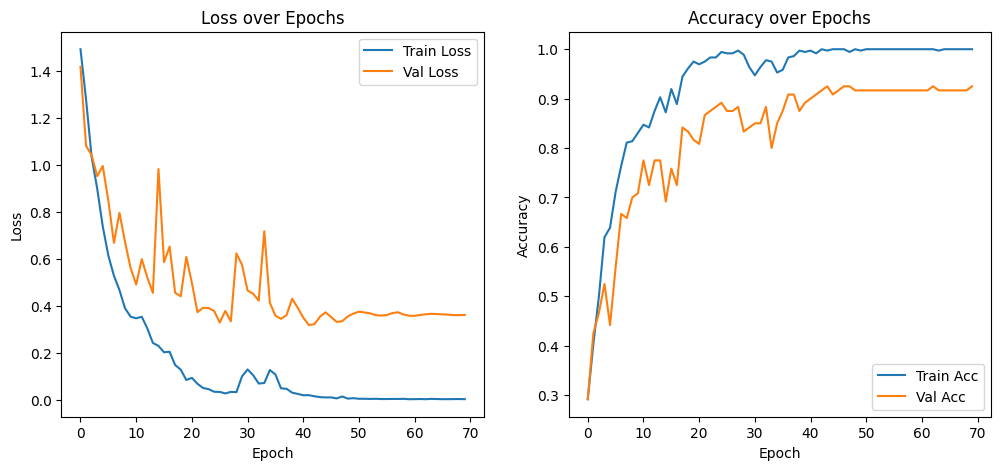

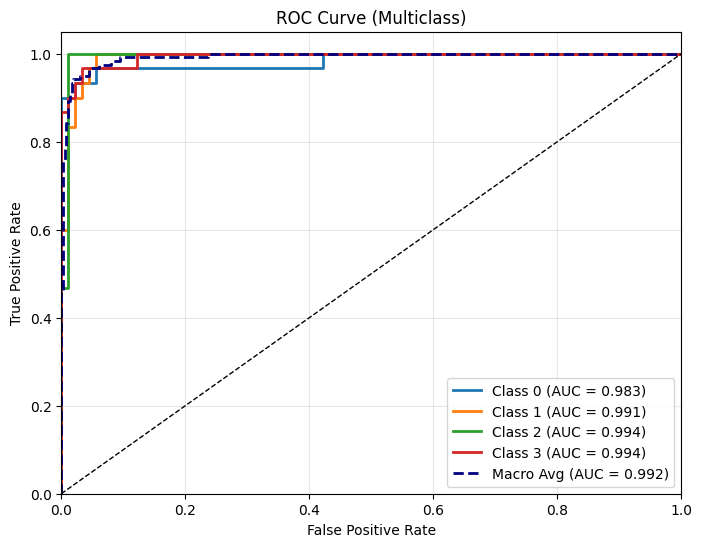


=== ROC-AUC Scores ===
Class 0: 0.9833
Class 1: 0.9915
Class 2: 0.9941
Class 3: 0.9937
Macro Avg ROC-AUC: 0.9922


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score
from collections import Counter
from sklearn.preprocessing import label_binarize

# ---- Dataset class ----
class EEGDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        if y.ndim > 1:
            y = np.argmax(y, axis=1)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


# ============================
# 🔹 Train / Val / Test Split
# ============================
print("Shape of training data being used:", X_train.shape, y_train.shape)
print("Shape of validation data being used:", X_val.shape, y_val.shape)
print("Shape of test data being used:", X_test.shape, y_test.shape)

# Original data for class weights
X_original = np.load("/content/drive/MyDrive/X_normalized.npy")
y_original = np.load("/content/drive/MyDrive/y_all.npy")

_, _, y_train_original_for_weights, _ = train_test_split(
    X_original, y_original, test_size=0.4, random_state=0, stratify=y_original
)
class_sample_counts = np.bincount(y_train_original_for_weights)

# ============================
# 🔹 DataLoaders
# ============================
try:
    train_loader, val_loader, test_loader
except NameError:
    print("Creating DataLoaders within this cell as they were not found.")
    train_dataset = EEGDataset(X_train, y_train)
    val_dataset   = EEGDataset(X_val, y_val)
    test_dataset  = EEGDataset(X_test, y_test)
    batch_size = 8
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# ============================
# 🔹 Model / Loss / Optimizer
# ============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = STEADYNet1D(num_classes=4, dropout=0.7).to(device)

class_weights = 1.0 / class_sample_counts
class_weights = class_weights / class_weights.sum()
criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float).to(device))

optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=9, factor=0.5)

# ============================
# 🔹 Train / Eval Functions
# ============================
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for X, y in loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    return running_loss / total, correct / total


def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    all_labels, all_probs = [], []
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            probs = torch.softmax(outputs, dim=1)
            loss = criterion(outputs, y)

            running_loss += loss.item() * X.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == y).sum().item()
            total += y.size(0)

            all_labels.append(y.cpu().numpy())
            all_probs.append(probs.cpu().numpy())

    all_labels = np.concatenate(all_labels)
    all_probs = np.concatenate(all_probs)
    return running_loss / total, correct / total, all_labels, all_probs


# ============================
# 🔹 Main Training Loop
# ============================
n_epochs = 70
best_val_acc = 0.0
best_epoch = 0
best_model_path = "best_model.pth"

train_losses, val_losses, test_losses = [], [], []
train_accs, val_accs, test_accs = [], [], []

for epoch in range(1, n_epochs + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion, device)
    test_loss, test_acc, _, _ = evaluate(model, test_loader, criterion, device)

    scheduler.step(val_loss)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    test_losses.append(test_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    test_accs.append(test_acc)

    print(f"Epoch [{epoch}/{n_epochs}]")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Val   Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
    print(f"  Test  Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch
        torch.save(model.state_dict(), best_model_path)
        print(f"✅ New best model saved (epoch {epoch}, Test acc: {test_acc:.4f})")

# ============================
# 🔹 Final Test Evaluation
# ============================
model.load_state_dict(torch.load(best_model_path))
final_test_loss, final_test_acc, y_true, y_prob = evaluate(model, test_loader, criterion, device)

print(f"\n🌟 Training finished.")
print(f"Best Model came from Epoch {best_epoch} with Val Acc: {best_val_acc:.4f}")
print(f"Final Test Acc (best model): {final_test_acc:.4f}")

# ============================
# 🔹 Plot Metrics
# ============================
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()
plt.show()

# ============================
# 🔹 ROC Curve (Multiclass)
# ============================
n_classes = 4
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Macro-average ROC
fpr["macro"], tpr["macro"], _ = roc_curve(y_true_bin.ravel(), y_prob.ravel())
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot ROC
plt.figure(figsize=(8,6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f"Class {i} (AUC = {roc_auc[i]:.3f})")

plt.plot(fpr["macro"], tpr["macro"], color="navy", linestyle="--", lw=2, label=f"Macro Avg (AUC = {roc_auc['macro']:.3f})")
plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Multiclass)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

print(f"\n=== ROC-AUC Scores ===")
for i in range(n_classes):
    print(f"Class {i}: {roc_auc[i]:.4f}")
print(f"Macro Avg ROC-AUC: {roc_auc['macro']:.4f}")



=== Classification Report ===
              precision    recall  f1-score   support

           0     0.9643    0.9000    0.9310        30
           1     0.9000    0.9000    0.9000        30
           2     0.9667    0.9667    0.9667        30
           3     0.9062    0.9667    0.9355        30

    accuracy                         0.9333       120
   macro avg     0.9343    0.9333    0.9333       120
weighted avg     0.9343    0.9333    0.9333       120


Accuracy: 0.9333
ROC AUC (macro, ovr): 0.9906


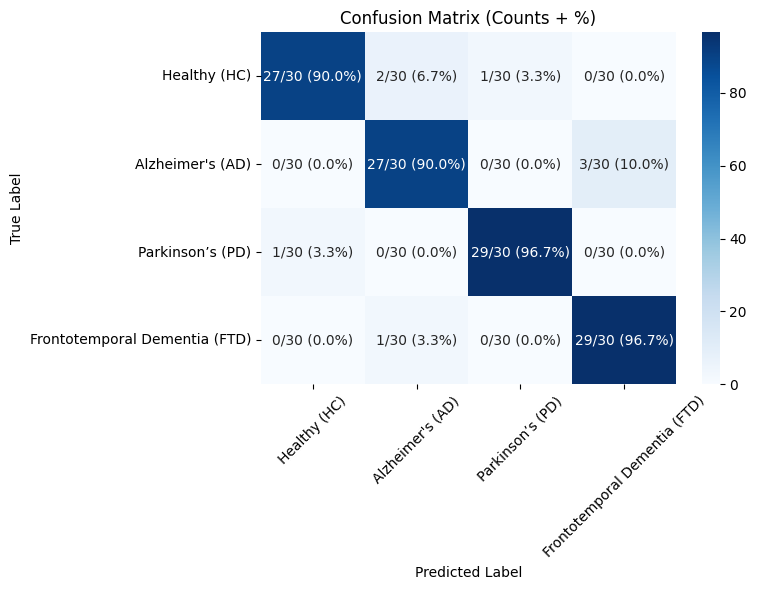


=== Class-wise Sensitivity & Specificity ===
Class 0:  Sensitivity (Recall) = 0.9000,  Specificity = 0.9889
Class 1:  Sensitivity (Recall) = 0.9000,  Specificity = 0.9667
Class 2:  Sensitivity (Recall) = 0.9667,  Specificity = 0.9889
Class 3:  Sensitivity (Recall) = 0.9667,  Specificity = 0.9667

Mean Sensitivity: 0.9333
Mean Specificity: 0.9778

=== Statistical Significance Test ===
z-statistic: 30.0089, p-value: 0.000000


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
from statsmodels.stats.proportion import proportions_ztest
import torch

# ============================
# 🔹 Function: Detailed Evaluation (with Confusion Matrix Plot)
# ============================
def detailed_evaluation(model, loader, device):
    model.eval()
    all_preds, all_labels, all_probs = [], [], []

    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X) # Unpack the output tuple

            probs = torch.softmax(outputs, dim=1).cpu().numpy()
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            labels = y.cpu().numpy()

            all_preds.extend(preds)
            all_labels.extend(labels)
            all_probs.extend(probs)

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    # ============================
    # 🔹 Basic Classification Metrics
    # ============================
    print("\n=== Classification Report ===")
    print(classification_report(all_labels, all_preds, digits=4))

    acc = accuracy_score(all_labels, all_preds)
    auc = roc_auc_score(all_labels, all_probs, multi_class='ovr', average='macro')
    print(f"\nAccuracy: {acc:.4f}")
    print(f"ROC AUC (macro, ovr): {auc:.4f}")

    # ============================
    # 🔹 Confusion Matrix (Formatted)
    # ============================
    cm = confusion_matrix(all_labels, all_preds)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    label_names_dict = {
        0: "Healthy (HC)",
        1: "Alzheimer's (AD)",
        2: "Parkinson’s (PD)",
        3: "Frontotemporal Dementia (FTD)"
    }
    class_names = [label_names_dict[i] for i in sorted(label_names_dict.keys())]

    # Prepare annotations (counts + percentages)
    annot = np.empty_like(cm).astype(str)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            annot[i, j] = f"{cm[i,j]}/{cm[i].sum()} ({cm_percent[i,j]:.1f}%)"

    plt.figure(figsize=(8,6))
    sns.heatmap(cm_percent, annot=annot, fmt="", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names, cbar=True)
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.title("Confusion Matrix (Counts + %)")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # ============================
    # 🔹 Sensitivity & Specificity
    # ============================
    num_classes = cm.shape[0]
    sensitivity = []
    specificity = []

    for i in range(num_classes):
        TP = cm[i, i]
        FN = cm[i, :].sum() - TP
        FP = cm[:, i].sum() - TP
        TN = cm.sum() - (TP + FP + FN)

        sens = TP / (TP + FN) if (TP + FN) > 0 else 0
        spec = TN / (TN + FP) if (TN + FP) > 0 else 0

        sensitivity.append(sens)
        specificity.append(spec)

    print("\n=== Class-wise Sensitivity & Specificity ===")
    for i in range(num_classes):
        print(f"Class {i}:  Sensitivity (Recall) = {sensitivity[i]:.4f},  Specificity = {specificity[i]:.4f}")

    print(f"\nMean Sensitivity: {np.mean(sensitivity):.4f}")
    print(f"Mean Specificity: {np.mean(specificity):.4f}")

    # ============================
    # 🔹 Statistical Significance Test
    # ============================
    chance_accuracy = 1.0 / num_classes
    successes = (all_preds == all_labels).sum()
    n_obs = len(all_labels)
    stat, pval = proportions_ztest(successes, n_obs, value=chance_accuracy)

    print("\n=== Statistical Significance Test ===")
    print(f"z-statistic: {stat:.4f}, p-value: {pval:.6f}")

    return all_labels, all_preds, all_probs, sensitivity, specificity

# ============================
# 🔹 Run Evaluation
# ============================
labels, preds, probs, sensitivity, specificity = detailed_evaluation(model, test_loader, device)